# Evaluation Analysis (Public Release)

Author: Stephen Roller <roller@fb.com>. Please direct questions to the ParlAI Github issues (https://github.com/facebookresearch/ParlAI/issues)

This notebook expects to be launched from inside your ParlAI installation (typically ~/ParlAI)

You will need to pip install a bunch of things, including pyro and pandas.

### General preparation

In [33]:
# bunch of imports and settings
import os
# make sure we never use CUDA on accident in this notebook
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import logging
logging.basicConfig(level=logging.WARNING, format='%(message)s')

# Make the notebook bigger
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12.0, 8.0]

import contextlib
import numpy as np
import scipy.stats
import logging
import time
import matplotlib.pyplot as plt


import torch
from torch import nn
import torch.nn.functional as F

import pyro
import pyro.infer
import pyro.infer.mcmc
import pyro.distributions as dist
from parlai.core.metrics import _f1_score, _bleu

pyro.enable_validation(False)

import pandas as pd
import json
import os
import seaborn as sns
from pprint import pprint
pd.options.display.float_format = '{:,.4f}'.format

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.set_option('display.max_columns', 500)



import projects.controllable_dialogue.controllable_seq2seq.controls as control
import projects.controllable_dialogue.controllable_seq2seq.nidf as nidf
import projects.controllable_dialogue.controllable_seq2seq.arora as arora
import parlai.core.dict as pcdict

In [79]:
# Get where the logs are stored
from parlai.core.params import ParlaiParser
basic_opt = ParlaiParser().parse_args([])

# make sure we download everything
from projects.controllable_dialogue.tasks.build import build
build(basic_opt)

DATA_FOLDER = os.path.join(basic_opt['datapath'], 'controllable_dialogue')
LOG_FOLDER = os.path.join(DATA_FOLDER, 'evaluation_logs')

# used for assertions later
NUM_TURNS = 6

# names of metrics
LIKERT_METRICS = ['fluency', 'enjoy', 'turing', 'make_sense', 'inquisitive', 'interest', 'avoid_rep', 'listen']

## Helper functions

In [80]:
# IO utilities
def render_conversation(row):
    result = []
    nice_scores = '&nbsp;&nbsp;&nbsp;&nbsp;'.join([
        '{}: {}'.format(m.title(), row[m])
        for m in LIKERT_METRICS
    ])
    for i, turn in enumerate(row['dialog']):
        is_bot = turn['speaker'] == 'model'
        speakername = row['model_name'] if is_bot else 'Human'
        text = turn['text']
        
        align = 'right' if is_bot else 'left'
        color = "white" if is_bot else "black"
        bgcolor = '#2391f7' if is_bot else '#e1e1e7'
        
        result.append(
            (
                '<div style="overflow: auto; padding: 1ex 0;">'
                '<div style="clear: both; float: {}; color: {}; background-color: {}; padding: 0.5em 1em; border-radius: 1em; max-width: 80%">'
                '<p style="margin: 0">{}: {}</p>'
                '</div>'
                '</div>'
            )
            .format(align, color, bgcolor, speakername, text)
        )
    return HTML(
        '<div style="background-color: white; margin: 0em; padding: 0.5em; '
        'font-family: sans-serif; font-size: 12pt; width: 99%;">'
        + ''.join(result) +
        '</div>'
    )

def render_many_converstions(table):
    return HTML('<hr />\n'.join(render_conversation(r).data for i, r in table.iterrows()))

# useful helpers

def modelname_subset(data, model_keys):
    return data[data.model_name.apply(lambda x: x in model_keys)]

def modeltype_subset(data, model_keys):
    return data[data.model_type.apply(lambda x: x in model_keys)].sort_values(['model_type', 'model_bucket'])


## Load conversation table

In [95]:
conversation_table = []
workers = set()

def get_many_logs():
    for fn in os.listdir(LOG_FOLDER):
        with open(os.path.join(LOG_FOLDER, fn)) as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                yield json.loads(line)

for item in get_many_logs():
    row = {}
    
    # flatten out and get the keys we need
    
    for key in ['model_name', 'model_type', 'model_bucket', 'dialog', 'assignment_id_hashed', 'evaluator_id_hashed']:
        row[key] = item[key]
    
    for key in ['enjoy', 'interest', 'listen', 'turing', 'avoid_rep', 'make_sense', 'fluency', 'persona_guess', 'inquisitive']:
        row[key] = item['evaluation_results'][key]
    
    conversation_table.append(row)
    
conversation_table = pd.DataFrame(conversation_table)
# mark certain columns as categories
conversation_table['evaluator_id_hashed'] = conversation_table.evaluator_id_hashed.astype('category')
conversation_table['model_name'] = conversation_table.model_name.astype('category')

# deterministic shuffle
conversation_table = conversation_table.sort_values('assignment_id_hashed').sample(frac=1, random_state=42)


# Raw table at a glance

In [96]:
conversation_table.groupby(["model_type", "model_bucket"]).mean()

avoid_rep  enjoy  fluency  inquisitive  \
model_type     model_bucket                                                 
baseline                              2.1441 2.3514   3.2252       2.4955   
greedy                                2.1567 2.3060   3.2015       2.0000   
human                                 2.9020 3.3137   3.6569       2.6275   
inquisitive-ct 000                    2.9533 2.9159   3.7009       2.4766   
               001                    2.8790 2.9355   3.5887       2.5161   
               004                    2.8750 2.8839   3.5893       2.5536   
               007                    2.8803 3.0704   3.6690       2.7465   
               010                    2.7429 2.9048   3.6952       2.7143   
               011                    2.7615 2.8440   3.5963       2.9358   
nidf_bfw       -04                    2.9024 2.7805   3.5528       2.5203   
               -10                    2.8475 2.4322   3.3390       2.3136   
               004                    2.9519 2.9904   3.6538       2.6538   
               006                    2.9266 2.9633   3.5229       2.5780   
               008                    2.7833 2.4000   2.6750       2.0333   
nidf_ct        000                    2.8302 2.9623   3.6226       2.6038   
               002                    2.8966 2.7759   3.6034       2.6638   
               004                    2.9200 2.8100   3.6500       2.5700   
               007                    2.8857 3.0000   3.6381       2.5619   
               009                    2.9018 2.8304   3.6071       2.3125   
repetition-bfw 2gram=005              2.6583 2.5583   3.5667       2.6750   
               2gram=012              2.8440 2.9083   3.5872       2.6330   
               2gram=035              2.9008 2.9504   3.7273       2.5455   
               2gram=035 stop=inf     2.8938 2.8938   3.6637       2.6991   
               2gram=999              2.8182 2.9587   3.6446       2.6529   
responsive     -10                    2.8571 2.4790   3.4202       2.3782   
               000                    2.9646 3.0088   3.7168       2.5575   
               005                    2.9000 2.8818   3.5091       2.5273   
               010                    2.7845 2.3879   3.0603       2.2241   
               013                    2.7130 2.1043   2.5391       2.1391   

                                   interest  listen  make_sense  \
model_type     model_bucket                                       
baseline                             2.3514  2.6306      3.3964   
greedy                               2.3582  2.7836      3.3284   
human                                3.2255  3.6373      3.8431   
inquisitive-ct 000                   2.8505  3.2897      3.5607   
               001                   2.8548  3.3226      3.6290   
               004                   2.8214  3.3661      3.6339   
               007                   2.9718  3.2254      3.5282   
               010                   2.7238  3.1238      3.5905   
               011                   2.8257  3.1835      3.5229   
nidf_bfw       -04                   2.6423  3.2846      3.5610   
               -10                   2.3814  3.0339      3.3305   
               004                   3.0000  3.3654      3.6346   
               006                   3.0550  3.2385      3.4954   
               008                   2.5500  2.6083      2.9083   
nidf_ct        000                   2.8585  3.2925      3.6604   
               002                   2.8017  3.1379      3.5000   
               004                   2.8000  3.2500      3.5000   
               007                   2.9048  3.3429      3.5905   
               009                   2.8393  3.0714      3.5804   
repetition-bfw 2gram=005             2.6083  3.0833      3.6000   
               2gram=012             2.8624  3.2110      3.6422   
               2gram=035             2.8760  3.2727      3.6777   
               2gram=035 stop=inf    2.

In [86]:
render_conversation(conversation_table.iloc[1])

# Bayesian Score computation (Kulikov, 2019)

In [109]:
# map back from model name to type/bucket
rmap = {}
for _, row in conversation_table.iterrows():
    model_name = row['model_name']
    if model_name not in rmap:
        rmap[model_name] = (row['model_bucket'], row['model_type'])

def infer_single_scores(table, fieldname, num_samples=100, warmup_steps=50):
    import torch
    torch.set_num_threads(1)
    t0 = time.time()
    observed_single_scores = torch.Tensor(list(table[fieldname]))
    num_likert_options = table[fieldname].nunique()
    
    def model_single_score(table):
        '''
        prior for each algorithm a
        p(m_a) = Unif(1, num_likert_options)

        prior for each single score given the models sampled mean
        p(s_a) = N(s_a|m_a, 1^2)
        '''
        zm = []
        for mi in range(table.model_name.nunique()):
            mu_ = pyro.sample("model-mean-{}".format(mi), dist.Uniform(1., float(num_likert_options)))
            zm.append(pyro.sample("model-{}".format(mi), dist.Normal(mu_, 1.)))

        '''
        prior for each turker's bias
        p(s_t) = N(s_t | 0, 1^2) - i.e., no bias from each turker a priori
        '''
        tm = []
        for ti in range(table.evaluator_id_hashed.nunique()):
            tm.append(pyro.sample("turker-mean-{}".format(ti), dist.Normal(0., 1.)))

        '''
        likelihood mean for each score (algorithm, score)
        p(s|a, t) = N(s| s_a + s_t, 1^2)
        '''
        mu = []
        for worker_id, model_id in zip(table.evaluator_id_hashed.cat.codes, table.model_name.cat.codes):
            mu.append(zm[model_id] + tm[worker_id])
        mu_ = torch.stack(mu)

        return pyro.sample("scores", dist.Normal(mu_, 1.))

    single_score_condition = pyro.condition(
            model_single_score, 
            data={'scores': observed_single_scores}
    )
    nuts_kernel = pyro.infer.mcmc.NUTS(single_score_condition, adapt_step_size=True, step_size=0.1)
    mcmc_run = pyro.infer.mcmc.MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps).run(table)
    
    score_marginal = pyro.infer.EmpiricalMarginal(
        mcmc_run,
        sites=["model-{}".format(mi) for mi in range(table.model_name.nunique())]
    )
    print('time taken: ', time.time()-t0)
    
    
    df = pd.DataFrame({
        'model_name': table.model_name.cat.categories,
        fieldname + '_mean': score_marginal.mean,
        fieldname + '_std': score_marginal.stddev
    })
    df['model_bucket'] = [rmap[mn][0] for mn in df['model_name']]
    df['model_type'] = [rmap[mn][1] for mn in df['model_name']]

    return df.set_index('model_name')


The following step runs bayesian analysis for each of the measures in parallel. You will want to decrease the number of CPUs down to what your computer has. The process takes about 45 minutes to compute.

Due to the stochastic nature of the process, you will get slightly different numbers than the ones reported in the paper. For convenience, we've included the ones from the paper to avoid this computation

In [124]:
if False:
    # run all the scores in parallel and join the results into one table

    # torch freaks out if we try to multiprocess with cuda
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    # keep each of the threads from stomping all over each other
    torch.set_num_threads(1)

    from multiprocessing import Pool

    with Pool(20) as pool:
        args = [(conversation_table, measure) for measure in LIKERT_METRICS]
        results_bayes = pd.concat(pool.starmap(infer_single_scores, args), axis=1)
else:
    bayes_data = '''
    model_name,fluency_mean,fluency_std,enjoy_mean,enjoy_std,turing_mean,turing_std,make_sense_mean,make_sense_std,inquisitive_mean,inquisitive_std,interest_mean,interest_std,avoid_rep_mean,avoid_rep_std,listen_mean,listen_std,model_type,model_bucket
baseline_model,3.0914075,0.12956531,2.2892258,0.10683544,1.7131442,0.13138857,3.345498,0.12607269,2.4151554,0.10993455,2.2880845,0.1420951,2.0833843,0.10571904,2.4713647,0.117826685,baseline,
greedy_model,3.0280933,0.10491706,2.2354803,0.107257016,1.7464366,0.11817865,3.233947,0.10319092,1.9487315,0.102352,2.290578,0.12559834,2.0841112,0.103310645,2.6239514,0.10315127,greedy,
human_eval,3.3617704,0.11792514,3.0442827,0.11493982,3.350734,0.113348715,3.681538,0.10894737,2.435449,0.11926911,2.9190917,0.111999035,2.790789,0.11871563,3.3168595,0.12881786,human,
inquisitive_model_ct_setting00,3.5139592,0.0967675,2.83884,0.12611441,2.4591095,0.10882996,3.4932463,0.119373344,2.3637252,0.09294756,2.7555757,0.0927458,2.8722908,0.11721186,3.1028264,0.09619383,inquisitive-ct,000
inquisitive_model_ct_setting01,3.4174926,0.10161546,2.876931,0.10879339,2.458943,0.11697992,3.549381,0.09925039,2.4650643,0.10826402,2.7947018,0.12823951,2.816174,0.109138474,3.138592,0.11414942,inquisitive-ct,001
inquisitive_model_ct_setting04,3.466806,0.11303423,2.8775582,0.09969538,2.4028935,0.09169132,3.5896442,0.09606155,2.5327814,0.12658662,2.830341,0.1268796,2.783972,0.122446634,3.2362282,0.10941788,inquisitive-ct,004
inquisitive_model_ct_setting07,3.5384107,0.0939107,2.9888,0.105407335,2.3539126,0.11059914,3.474378,0.10486635,2.6636062,0.119133025,2.9173691,0.117349364,2.8096406,0.1004062,3.1082954,0.09788587,inquisitive-ct,007
inquisitive_model_ct_setting10,3.5227299,0.12035936,2.8661678,0.11492953,2.3464699,0.11804114,3.5265877,0.12227977,2.6337807,0.11855745,2.6558821,0.10226053,2.6730306,0.12550566,2.9447966,0.109267645,inquisitive-ct,010
inquisitive_model_ct_setting10_better,3.420784,0.12406063,2.7386124,0.09353278,2.1931195,0.13429101,3.450729,0.13293721,2.7863073,0.111801624,2.7376783,0.111998275,2.6759079,0.11800891,2.9955559,0.12491749,inquisitive-ct,011
interesting_nidf_model_bfw_setting_04,3.4463646,0.13350625,2.9587107,0.12454782,2.4409015,0.11551093,3.5361714,0.10621155,2.5572858,0.08596149,2.9410334,0.11254286,2.840033,0.10043833,3.1984024,0.09754762,nidf_bfw,004
interesting_nidf_model_bfw_setting_06,3.3424668,0.09006725,2.9053752,0.097677216,2.3083365,0.11380971,3.4079204,0.116244145,2.5260317,0.11763178,2.9328823,0.119851254,2.8065453,0.09133208,3.0851126,0.09660692,nidf_bfw,006
interesting_nidf_model_bfw_setting_08,2.5359437,0.11638034,2.3928986,0.12092932,1.8046832,0.12724209,2.8720655,0.11232278,2.0019753,0.097686924,2.4934795,0.11799547,2.7020395,0.10965349,2.4661036,0.10257839,nidf_bfw,008
interesting_nidf_model_bfw_setting_minus_04,3.3714204,0.102036715,2.7597752,0.11824679,2.3626835,0.10884776,3.5159597,0.108949505,2.4624243,0.110119894,2.621436,0.11877783,2.8268204,0.10388491,3.1394558,0.094563544,nidf_bfw,-04
interesting_nidf_model_bfw_setting_minus_10,3.188879,0.12436492,2.4090981,0.12411542,2.1500096,0.1128042,3.2827806,0.11560405,2.2804828,0.1344875,2.351124,0.121478364,2.7615042,0.11347523,2.886509,0.10520854,nidf_bfw,-10
interesting_nidf_model_ct_setting0,3.4431455,0.11906912,2.9258559,0.088641025,2.3770676,0.11373025,3.6066294,0.10947405,2.5631077,0.122011304,2.8404248,0.12301018,2.788957,0.096725754,3.1246283,0.12607282,nidf_ct,000
interesting_nidf_model_ct_setting2,3.389251,0.13110022,2.7392132,0.11038114,2.3120344,0.12750752,3.4655373,0.10412794,2.5648835,0.12711605,2.7370658,0.11907516,2.781668,0.119834706,2.9915996,0.10762761,nidf_ct,002
interesting_nidf_model_ct_setting4,3.4366372,0.13992369,2.795612,0.1315953,2.3171048,0.13324456,3.4565122,0.12817147,2.5133355,0.11968733,2.7807126,0.15289873,2.8235056,0.098016724,3.085936,0.12654012,nidf_ct,004
interesting_nidf_model_ct_setting7,3.4267304,0.11089812,2.91389,0.13190652,2.4536288,0.095813766,3.5490704,0.109761,2.4927237,0.11294685,2.8147955,0.121712856,2.812701,0.12364607,3.1512172,0.12203714,nidf_ct,007
interesting_nidf_model_ct_setting9,3.412071,0.11562859,2.7782488,0.09793116,2.3476672,0.13273424,3.5078192,0.123752415,2.2768347,0.10855014,2.791978,0.10660777,2.7957282,0.1290695,2.9055562,0.10904883,nidf_ct,009
repetition_model_setting05,3.351136,0.12485303,2.5351877,0.11802207,2.131792,0.11483303,3.4810336,0.11032247,2.633227,0.11012598,2.5645876,0.11315254,2.6154072,0.10460297,2.925591,0.11182627,repetition-bfw,2gram=005
repetition_model_setting12,3.403044,0.12195272,2.818021,0.12892646,2.2676632,0.12410987,3.5339706,0.138091,2.5448759,0.08994768,2.7566962,0.1035419,2.7767127,0.09308626,3.0484388,0.110010505,repetition-bfw,2gram=012
repetition_model_setting35,3.562523,0.102048345,2.934537,0.09988889,2.4272463,0.107678376,3.6171374,0.12241684,2.47073,0.10978695,2.8317904,0.09658501,2.826065,0.11344152,3.1369538,0.10203378,repetition-bfw,2gram=035
repetition_model_setting35_settinginf,3.5319638,0.10463153,2.8183765,0.12304195,2.3975408,0.10982047,3.5779467,0.14254314,2.62365,0.1294855,2.843848,0.12449841,2.8550565,0.12010231,3.103962,0.109406754,repetition-bfw,2gram=035 stop=inf
repetition_model_settinginf,3.4903002,0.12059033,2.874239,0.1358771,2.3232102,0.1309247,3.5929792,0.116237886,2.555877,0.10959805,2.7502258,0.11547001,2.7356553,0.114207745,3.127551,0.11856033,repetition-bfw,2gram=999
responsiveness_model_bfw_setting_00,3.5512834,0.087748855,2.9677284,0.11360309,2.6231253,0.10570546,3.7040608,0.10423539,2.4773164,0.100650065,2.8829346,0.11615346,2.8743443,0.115949884,3.2102318,0.09360844,responsive,000
responsiveness_model_bfw_setting_05,3.3485637,0.12327652,2.8315463,0.09458454,2.398068,0.11602921,3.407857,0.115517996,2.506635,0.12592898,2.803587,0.12773731,2.7892473,0.10135295,3.1325374,0.11519348,responsive,005
responsiveness_model_bfw_setting_10,2.9316738,0.11106751,2.4206061,0.11819174,1.9520544,0.122140095,3.1197522,0.09797036,2.1957242,0.11881691,2.5557888,0.11651121,2.7393322,0.10824369,2.9012582,0.12356319,responsive,010
responsiveness_model_bfw_setting_13,2.397673,0.08854504,2.0601296,0.10622171,1.7427883,0.11313255,2.6316466,0.10069777,2.0721536,0.10736318,2.2488096,0.11831513,2.6300664,0.12108313,2.486768,0.1420562,responsive,013
responsiveness_model_bfw_setting_minus_10,3.2559185,0.10904983,2.4534166,0.122486725,1.9554462,0.10266632,3.1158836,0.11584097,2.312914,0.1201041,2.473524,0.119496204,2.7670064,0.11804217,2.7265708,0.108767524,responsive,-10
    '''.strip()
    import io
    results_bayes = pd.read_csv(io.StringIO(bayes_data)).set_index('model_name')
    
results_bayes

,fluency_mean,fluency_std,enjoy_mean,enjoy_std,turing_mean,turing_std,make_sense_mean,make_sense_std,inquisitive_mean,inquisitive_std,interest_mean,interest_std,avoid_rep_mean,avoid_rep_std,listen_mean,listen_std,model_type,model_bucket
model_name,,,,,,,,,,,,,,,,,,
baseline_model,3.0914,0.1296,2.2892,0.1068,1.7131,0.1314,3.3455,0.1261,2.4152,0.1099,2.2881,0.1421,2.0834,0.1057,2.4714,0.1178,baseline,NaN
greedy_model,3.0281,0.1049,2.2355,0.1073,1.7464,0.1182,3.2339,0.1032,1.9487,0.1024,2.2906,0.1256,2.0841,0.1033,2.6240,0.1032,greedy,NaN
human_eval,3.3618,0.1179,3.0443,0.1149,3.3507,0.1133,3.6815,0.1089,2.4354,0.1193,2.9191,0.1120,2.7908,0.1187,3.3169,0.1288,human,NaN
inquisitive_model_ct_setting00,3.5140,0.0968,2.8388,0.1261,2.4591,0.1088,3.4932,0.1194,2.3637,0.0929,2.7556,0.0927,2.8723,0.1172,3.1028,0.0962,inquisitive-ct,000
inquisitive_model_ct_setting01,3.4175,0.1016,2.8769,0.1088,2.4589,0.1170,3.5494,0.0993,2.4651,0.1083,2.7947,0.1282,2.8162,0.1091,3.1386,0.1141,inquisitive-ct,001
inquisitive_model_ct_setting04,3.4668,0.1130,2.8776,0.0997,2.4029,0.0917,3.5896,0.0961,2.5328,0.1266,2.8303,0.1269,2.7840,0.1224,3.2362,0.1094,inquisitive-ct,004
inquisitive_model_ct_setting07,3.5384,0.0939,2.9888,0.1054,2.3539,0.1106,3.4744,0.1049,2.6636,0.1191,2.9174,0.1173,2.8096,0.1004,3.1083,0.0979,inquisitive-ct,007
inquisitive_model_ct_setting10,3.5227,0.1204,2.8662,0.1149,2.3465,0.1180,3.5266,0.1223,2.6338,0.1186,2.6559,0.1023,2.6730,0.1255,2.9448,0.1093,inquisitive-ct,010
inquisitive_model_ct_setting10_better,3.4208,0.1241,2.7386,0.0935,2.1931,0.1343,3.4507,0.1329,2.7863,0.1118,2.7377,0.1120,2.6759,0.1180,2.9956,0.1249,inquisitive-ct,011


# Graph Generation

Graphs will be placed in ~/plots/

In [127]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12.0, 8.0]

plt.rcParams['axes.facecolor'] = '#FFFFFF'
plt.rcParams['grid.color'] = '#E3E3E3'
plt.rcParams['legend.framealpha'] = 1.0
plt.rcParams['axes.labelweight'] = 'normal'

MAIN_COLOR = 'k'

CM = 0.393700787

SOLO_FIG_SIZE = (16 * CM, CM * 16 * 0.5)

nice_names = {
    'repetition++': 'Repetition-controlled baseline+',
    'baseline_model': 'Beam search baseline',
    'inquisitive-ct': 'Question-controlled CT',
    'human_eval': 'Human',
    'repetition_model_setting35_settinginf': 'Repetition-controlled baseline',
    'nidf_ct': 'Specificity-controlled CT',
    'nidf_bfw': 'Specificity-controlled WD',
    'responsive': 'Response-related controlled WD',
    'greedy_model': 'Greedy search baseline',
    'repetition_model_setting05': 'Extrep\nbigram -0.5',
    'repetition_model_setting12': 'Extrep\nbigram -1.25',
    'repetition_model_setting35': 'Extrep\nbigram -3.5',
    'repetition_model_settinginf': 'Extrep\nbigram -inf',
}

nice_names_rep = {
    **nice_names,

    'repetition_model_setting35_settinginf': 'Extrep bigram -3.5\n+ unigram -inf',
    'repetition++': '+ Partner\nIntrep bigram',

}

nice_colors = {
    'repetition_model_setting35_settinginf': 'C2',
    'repetition++': 'C2',
    'human_eval': '#d89a2f',
    'baseline_model': 'C1',
    'greedy_model': 'C5',
    'inquisitive_model_ct_setting07': 'C3',
    'interesting_nidf_model_bfw_setting_04': 'C6',
}
nice_styles = {
    'repetition_model_setting35_settinginf': '--',
    'repetition++': '--',
    'human_eval': '-.',
    'baseline_model': ':',
    'greedy_model': '--',
}
nice_metric_names = {
    'enjoy': 'Engagingness',
    'interest': 'Interestingness',
    'inquisitive': 'Inquisitiveness',
    'listen': 'Listening',
    'avoid_rep': 'Avoiding Repetition',
    'fluency': 'Fluency',
    'make_sense': 'Making Sense',
    'turing': 'Humanness', 
    'persona_guess': 'Persona retrieval',
}

In [128]:
LIKERT_METRICS = ['fluency', 'enjoy', 'turing', 'make_sense', 'inquisitive', 'interest', 'avoid_rep', 'listen']
def modelname_subset(data, model_keys):
    return data[data.model_name.apply(lambda x: x in model_keys)]

def modeltype_subset(data, model_keys):
    return data[data.model_type.apply(lambda x: x in model_keys)].sort_values(['model_type', 'model_bucket'])

import os
HOME = os.environ['HOME']
try:
    os.mkdir(HOME + '/plots')
except IOError:
    pass

Output latex for the raw scores table

In [132]:
results_raw = conversation_table.copy().groupby(['model_name', 'model_type', 'model_bucket']).aggregate({
    k: [np.mean, np.std]
    for k in LIKERT_METRICS + ['persona_guess']
}).reset_index()
results_raw.columns = ['_'.join([c for c in col if c.strip()]) for col in results_raw.columns.values]
results_raw = results_raw.set_index('model_name')

nice_raw = []
colmax = results_raw[results_raw.index != 'human_eval'].max(axis=0)
for model_name, row in results_raw.iterrows():
    x = {}
    for m in LIKERT_METRICS + ['persona_guess']:
        val = '{:.2f} $\\pm$ {:.2f}'.format(row[m + '_mean'], row[m + '_std'])
        if row[m + '_mean'] == colmax[m + '_mean']:
            val = '{\\bf ' + val + '}'
        x[nice_metric_names[m]] = val
    x['model_name'] = nice_names.get(
        model_name,
        nice_names.get(
            row['model_type'],
            row['model_type']
        ) + ' ' + str(row['model_bucket'])
    )
    nice_raw.append(x)

nice_raw = pd.DataFrame(nice_raw).set_index('model_name')
print(nice_raw.to_latex(escape=False))

\begin{tabular}{llllllllll}
\toprule
{} &    Avoiding Repetition &           Engagingness &                Fluency &              Humanness &        Inquisitiveness &        Interestingness &              Listening &           Making Sense &      Persona retrieval \\
model_name                         &                        &                        &                        &                        &                        &                        &                        &                        &                        \\
\midrule
Beam search baseline               &        2.14 $\pm$ 0.72 &        2.35 $\pm$ 1.01 &        3.23 $\pm$ 0.93 &        1.81 $\pm$ 0.87 &        2.50 $\pm$ 0.72 &        2.35 $\pm$ 0.98 &        2.63 $\pm$ 0.85 &        3.40 $\pm$ 0.77 &        0.77 $\pm$ 0.42 \\
Greedy search baseline             &        2.16 $\pm$ 0.72 &        2.31 $\pm$ 1.08 &        3.20 $\pm$ 0.81 &        1.78 $\pm$ 0.90 &        2.00 $\pm$ 0.81 &        2.36 $\pm$ 0.98 &        2.7

In [133]:
results_raw

,model_type,model_bucket,fluency_mean,fluency_std,enjoy_mean,enjoy_std,turing_mean,turing_std,make_sense_mean,make_sense_std,inquisitive_mean,inquisitive_std,interest_mean,interest_std,avoid_rep_mean,avoid_rep_std,listen_mean,listen_std,persona_guess_mean,persona_guess_std
model_name,,,,,,,,,,,,,,,,,,,,
baseline_model,baseline,,3.2252,0.9311,2.3514,1.0149,1.8108,0.8688,3.3964,0.7661,2.4955,0.7246,2.3514,0.9784,2.1441,0.7242,2.6306,0.8520,0.7748,0.4196
greedy_model,greedy,,3.2015,0.8114,2.3060,1.0846,1.7836,0.8958,3.3284,0.7537,2.0000,0.8134,2.3582,0.9841,2.1567,0.7240,2.7836,0.8439,0.8657,0.3423
human_eval,human,,3.6569,0.7105,3.3137,0.9008,3.4020,0.7993,3.8431,0.5217,2.6275,0.6281,3.2255,0.8314,2.9020,0.3856,3.6373,0.6260,0.9216,0.2702
inquisitive_model_ct_setting00,inquisitive-ct,000,3.7009,0.5358,2.9159,0.9020,2.4860,0.9651,3.5607,0.6613,2.4766,0.7183,2.8505,0.9296,2.9533,0.2527,3.2897,0.6869,0.8598,0.3488
inquisitive_model_ct_setting01,inquisitive-ct,001,3.5887,0.6627,2.9355,0.9348,2.4677,0.9494,3.6290,0.5480,2.5161,0.6924,2.8548,0.8989,2.8790,0.3274,3.3226,0.7275,0.8468,0.3617
inquisitive_model_ct_setting04,inquisitive-ct,004,3.5893,0.7297,2.8839,0.9372,2.4196,1.0708,3.6339,0.5850,2.5536,0.6554,2.8214,0.8512,2.8750,0.3826,3.3661,0.7352,0.8393,0.3689
inquisitive_model_ct_setting07,inquisitive-ct,007,3.6690,0.5422,3.0704,0.9043,2.4225,0.9772,3.5282,0.7597,2.7465,0.5766,2.9718,0.8417,2.8803,0.3667,3.2254,0.7569,0.8028,0.3993
inquisitive_model_ct_setting10,inquisitive-ct,010,3.6952,0.5024,2.9048,0.9253,2.4286,1.0364,3.5905,0.6606,2.7143,0.5669,2.7238,0.8825,2.7429,0.4605,3.1238,0.7298,0.7905,0.4089
inquisitive_model_ct_setting10_better,inquisitive-ct,011,3.5963,0.6400,2.8440,0.9445,2.2569,0.9661,3.5229,0.6749,2.9358,0.5656,2.8257,0.9413,2.7615,0.4887,3.1835,0.7954,0.7156,0.4532


In [135]:

# things that have two names
results_bayes.loc['repetition++'] = results_bayes.loc['responsiveness_model_bfw_setting_00']
results_bayes.loc['repetition++','model_type'] = 'repetition-bfw'

results_bayes.loc['interesting_nidf_model_bfw_setting_00'] = results_bayes.loc['repetition_model_setting35_settinginf']
results_bayes.loc['interesting_nidf_model_bfw_setting_00','model_type'] = 'nidf_bfw'
results_bayes.loc['interesting_nidf_model_bfw_setting_00','model_bucket'] = '00'

results_bayes.loc['inquisitive_model_ct_setting10_better', 'model_bucket'] = '12'

# prep results
altered = results_bayes.copy().reset_index()
altered["model_bucket"] = altered.model_bucket.astype('category')

In [136]:
altered

,model_name,fluency_mean,fluency_std,enjoy_mean,enjoy_std,turing_mean,turing_std,make_sense_mean,make_sense_std,inquisitive_mean,inquisitive_std,interest_mean,interest_std,avoid_rep_mean,avoid_rep_std,listen_mean,listen_std,model_type,model_bucket
0,baseline_model,3.0914,0.1296,2.2892,0.1068,1.7131,0.1314,3.3455,0.1261,2.4152,0.1099,2.2881,0.1421,2.0834,0.1057,2.4714,0.1178,baseline,NaN
1,greedy_model,3.0281,0.1049,2.2355,0.1073,1.7464,0.1182,3.2339,0.1032,1.9487,0.1024,2.2906,0.1256,2.0841,0.1033,2.6240,0.1032,greedy,NaN
2,human_eval,3.3618,0.1179,3.0443,0.1149,3.3507,0.1133,3.6815,0.1089,2.4354,0.1193,2.9191,0.1120,2.7908,0.1187,3.3169,0.1288,human,NaN
3,inquisitive_model_ct_setting00,3.5140,0.0968,2.8388,0.1261,2.4591,0.1088,3.4932,0.1194,2.3637,0.0929,2.7556,0.0927,2.8723,0.1172,3.1028,0.0962,inquisitive-ct,000
4,inquisitive_model_ct_setting01,3.4175,0.1016,2.8769,0.1088,2.4589,0.1170,3.5494,0.0993,2.4651,0.1083,2.7947,0.1282,2.8162,0.1091,3.1386,0.1141,inquisitive-ct,001
5,inquisitive_model_ct_setting04,3.4668,0.1130,2.8776,0.0997,2.4029,0.0917,3.5896,0.0961,2.5328,0.1266,2.8303,0.1269,2.7840,0.1224,3.2362,0.1094,inquisitive-ct,004
6,inquisitive_model_ct_setting07,3.5384,0.0939,2.9888,0.1054,2.3539,0.1106,3.4744,0.1049,2.6636,0.1191,2.9174,0.1173,2.8096,0.1004,3.1083,0.0979,inquisitive-ct,007
7,inquisitive_model_ct_setting10,3.5227,0.1204,2.8662,0.1149,2.3465,0.1180,3.5266,0.1223,2.6338,0.1186,2.6559,0.1023,2.6730,0.1255,2.9448,0.1093,inquisitive-ct,010
8,inquisitive_model_ct_setting10_better,3.4208,0.1241,2.7386,0.0935,2.1931,0.1343,3.4507,0.1329,2.7863,0.1118,2.7377,0.1120,2.6759,0.1180,2.9956,0.1249,inquisitive-ct,12
9,interesting_nidf_model_bfw_setting_04,3.4464,0.1335,2.9587,0.1245,2.4409,0.1155,3.5362,0.1062,2.5573,0.0860,2.9410,0.1125,2.8400,0.1004,3.1984,0.0975,nidf_bfw,004


In [137]:
nice_bayes = []
colmax = results_bayes[results_bayes.index != 'human_eval'].max(axis=0)
for model_name, row in results_bayes.iterrows():
    x = {}
    for m in LIKERT_METRICS:
        val = '{:.2f} $\\pm$ {:.2f}'.format(row[m + '_mean'], row[m + '_std'])
        if row[m + '_mean'] == colmax[m + '_mean']:
            val = '{\\bf ' + val + '}'
        x[nice_metric_names[m]] = val
    x['model_name'] = nice_names.get(
        model_name,
        nice_names.get(
            row['model_type'],
            row['model_type']
        ) + ' ' + str(row['model_bucket'])
    )
    nice_bayes.append(x)

nice_bayes = pd.DataFrame(nice_bayes).set_index('model_name')
print(nice_bayes.to_latex(escape=False))

\begin{tabular}{lllllllll}
\toprule
{} &    Avoiding Repetition &           Engagingness &                Fluency &              Humanness &        Inquisitiveness &        Interestingness &              Listening &           Making Sense \\
model_name                         &                        &                        &                        &                        &                        &                        &                        &                        \\
\midrule
Beam search baseline               &        2.08 $\pm$ 0.11 &        2.29 $\pm$ 0.11 &        3.09 $\pm$ 0.13 &        1.71 $\pm$ 0.13 &        2.42 $\pm$ 0.11 &        2.29 $\pm$ 0.14 &        2.47 $\pm$ 0.12 &        3.35 $\pm$ 0.13 \\
Greedy search baseline             &        2.08 $\pm$ 0.10 &        2.24 $\pm$ 0.11 &        3.03 $\pm$ 0.10 &        1.75 $\pm$ 0.12 &        1.95 $\pm$ 0.10 &        2.29 $\pm$ 0.13 &        2.62 $\pm$ 0.10 &        3.23 $\pm$ 0.10 \\
Human                              

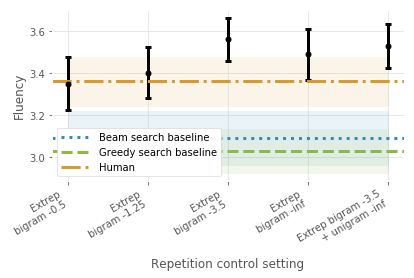

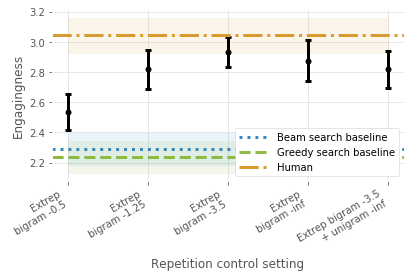

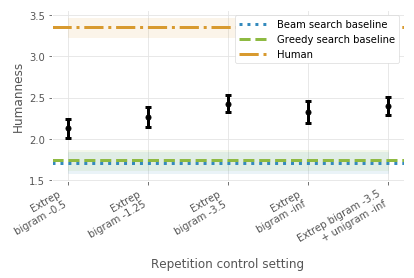

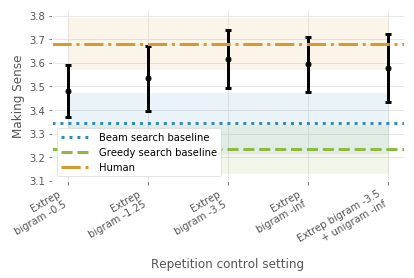

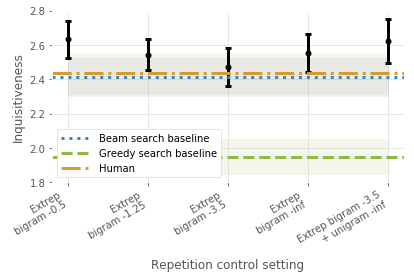

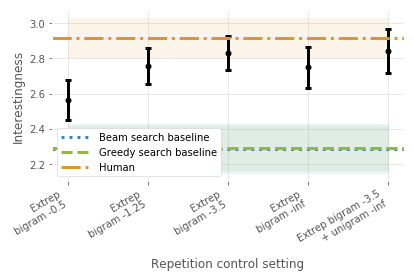

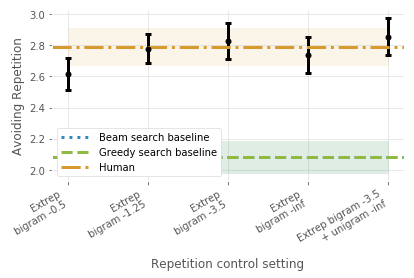

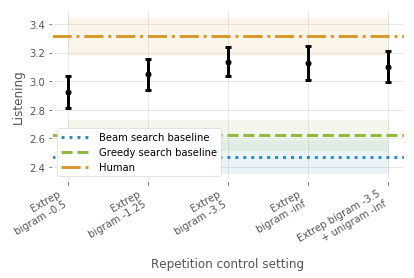

In [140]:
def tryint(x):
    if not isinstance(x, str):
        return x
    try:
        return int(x)
    except:
        return -1

def plot_by_bucket(treatments, baselines, metric, fill=True, abslim=None, fig=None, bucket_field='model_bucket',
                  title=None, xaxis=None, xtick_labels=None, xtick_values=None, use_title=False):
    metric_mean = metric + '_mean'
    metric_std = metric + '_std'
    
    if fig is None:
        fig = plt.gca()
    
    legend = []
    
    legend_names = []

    for label, treatment in treatments.groupby('model_type'):
        col = MAIN_COLOR
        treatment = treatment.copy()
        treatment['__bucket_field'] = treatment[bucket_field].apply(tryint)
        treatment = treatment.sort_values('__bucket_field')
        buckets = treatment['__bucket_field']
        l = fig.plot(
            buckets,
            treatment[metric_mean],
            'o',
            lw=3,
            color=col,
            linestyle='-',
        )
        legend_names.append(nice_names[label])
        legend.append(l[0])
        if fill:
            fig.fill_between(
                buckets,
                treatment[metric_mean] - treatment[metric_std],
                treatment[metric_mean] + treatment[metric_std],
                color=col,
                alpha=0.1,
            )

    for label, baseline in baselines.groupby('model_name', observed=True):
        _, baseline = next(baseline.iterrows())
        col = nice_colors[label]
        legend_names.append(nice_names[label])
        if fill:
            fig.fill_between(
                xtick_values if xtick_values else buckets,
                baseline[metric_mean] - baseline[metric_std],
                baseline[metric_mean] + baseline[metric_std],
                color=col,
                alpha=0.1,
            )
        l = fig.axhline(y=baseline[metric_mean], color=col, ls=nice_styles[label], lw=3)
        legend.append(l)
    
    if use_title:
        fig.set_title(xaxis)
    elif use_title is False:
        fig.set_xlabel(xaxis)
    if xtick_values:
        fig.set_xticks(xtick_values)
        fig.set_xticklabels(xtick_labels)
    fig.set_ylabel(nice_metric_names[metric])
    if abslim:
        fig.set_ylim(abslim[0], abslim[1])
    
    if legend_names:
        fig.legend(legend, legend_names, handlelength=3)

    return fig

repetition_order = [
    'repetition_model_setting05',
    'repetition_model_setting12',
    'repetition_model_setting35',
    'repetition_model_settinginf',
    'repetition_model_setting35_settinginf',
#     'repetition++',
]

def wrap(word):
    return word
    if len(word) < 20:
        return word
    return '\n'.join(word.split())

def plot_repetition_bfw(metric, figgca, abslim, use_title=False, xaxis='Repetition control setting'):
    metric_mean = metric + '_mean'
    metric_std = metric + '_std'
    
    for i, mn in enumerate(repetition_order):
        mnsubset = modelname_subset(altered, [mn])
        figgca.errorbar(
            x=[i],
            y=mnsubset[metric_mean],
            yerr=mnsubset[metric_std],
            color='k',
            marker='o',
            lw=3,
            capsize=3,
            capthick=3,
            markersize=5,
        )

    descriptions = [wrap(nice_names_rep[mn]) for mn in repetition_order]
    
    figgca.set_xticks(range(len(repetition_order)))
    figgca.set_xticklabels(
        descriptions,
        rotation=30,
        multialignment='right',
        horizontalalignment='right',
    )
    legend = []
    legend_names = []
    for bl in ["baseline_model", "greedy_model", "human_eval"]:
        col = nice_colors[bl]
        l = figgca.axhline(y=results_bayes.loc[bl, metric_mean], color=col, ls=nice_styles[bl], lw=3)
        legend.append(l)
        legend_names.append(nice_names[bl])
        
        figgca.fill_between(
            range(len(repetition_order)),
            results_bayes.loc[bl, metric_mean] - results_bayes.loc[bl, metric_std],
            results_bayes.loc[bl, metric_mean] + results_bayes.loc[bl, metric_std],
            color=col,
            alpha=0.1,
        )

    if use_title:
        figgca.set_title(xaxis)
    elif use_title is False:
        figgca.set_xlabel(xaxis)
    
    figgca.set_ylabel(nice_metric_names[metric])
    figgca.legend(legend, legend_names, handlelength=3)
    if abslim:
        figgca.set_ylim(abslim[0], abslim[1])
    
    return figgca

for i, m in enumerate(LIKERT_METRICS):
    fig = plt.figure(figsize=SOLO_FIG_SIZE)
    plot_repetition_bfw(m, fig.gca(), None)
    fig.savefig(HOME + "/plots/{}_{}.pdf".format('repetition', m), bbox_inches='tight', transparent=True)

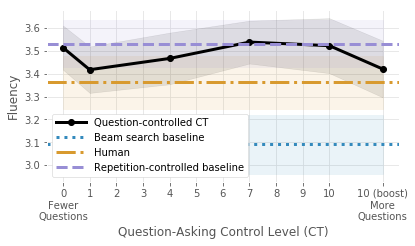

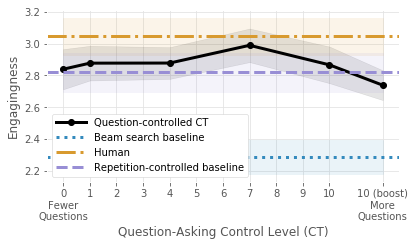

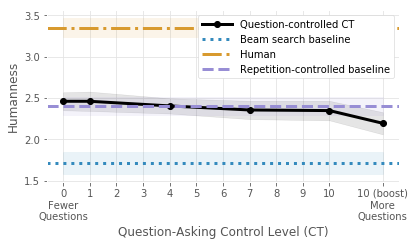

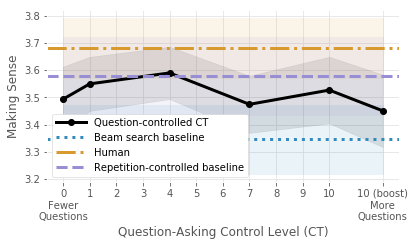

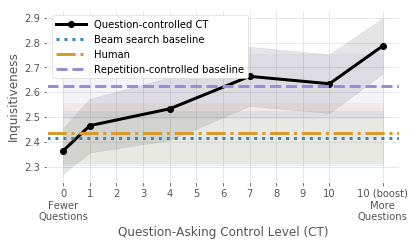

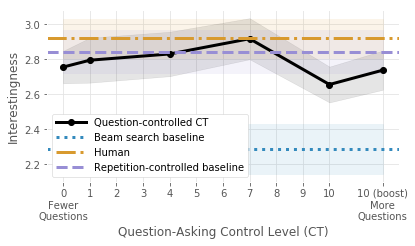

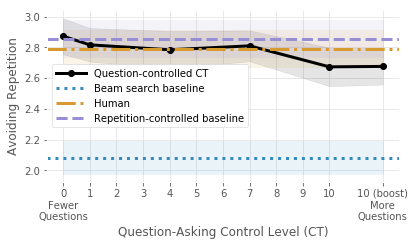

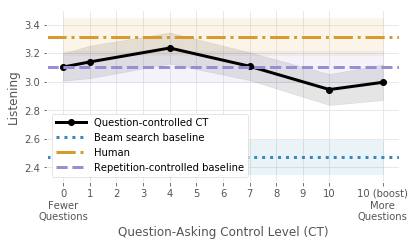

In [141]:
def plot_inquisitive_ct(metric, figgca, abslim, use_title=False, xaxis='Question-Asking Control Level (CT)'):
    plot_by_bucket(
        modeltype_subset(altered, ["inquisitive-ct"]),
        modelname_subset(altered, ["repetition_model_setting35_settinginf", "baseline_model", "human_eval"]),
        metric,
        figgca,
        xaxis=xaxis,
        xtick_values=list(range(11)) + [12],
        xtick_labels=['0\nFewer\nQuestions', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '10 (boost)\nMore\nQuestions'],
        abslim=abslim,
        use_title=use_title,
    )

for i, m in enumerate(LIKERT_METRICS):
    fig = plt.figure(figsize=SOLO_FIG_SIZE)
    plot_inquisitive_ct(m, fig.gca(), None)
    fig.savefig(HOME + "/plots/{}_{}.pdf".format('inquisitive-ct', m), bbox_inches='tight', transparent=True)

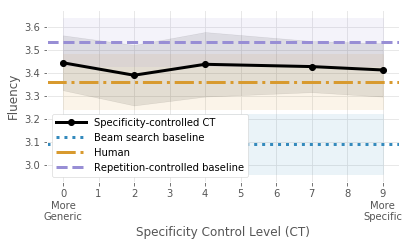

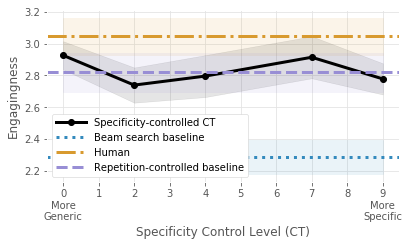

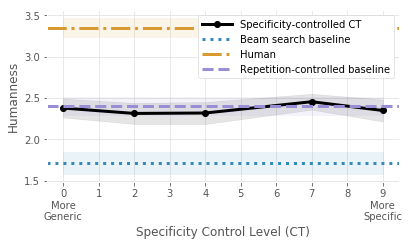

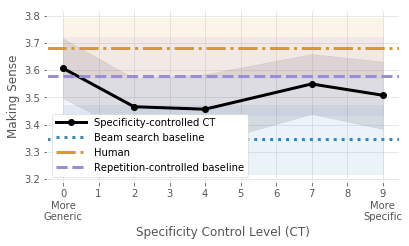

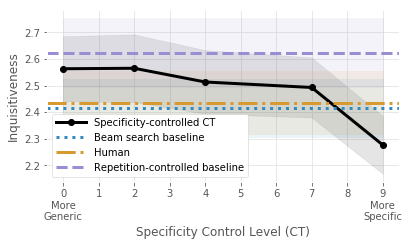

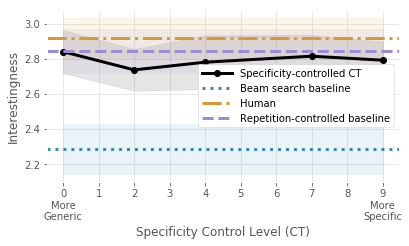

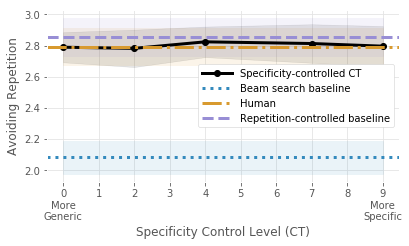

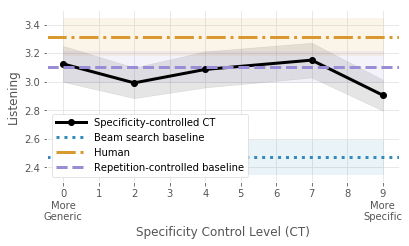

In [142]:
def plot_nidf_ct(metric, figgca, abslim, xaxis='Specificity Control Level (CT)', use_title=False):
    plot_by_bucket(
        modeltype_subset(altered, ["nidf_ct"]),
        modelname_subset(altered, ["repetition_model_setting35_settinginf", "repetition_model_setting35_settinginf_redo", "baseline_model", "human_eval"]),
        metric,
        fig=figgca,
        xtick_values=range(10),
        xtick_labels=['0\nMore\nGeneric'] + list(map(str, range(1, 9))) + ['9\nMore\nSpecific'],
        xaxis=xaxis,
        use_title=use_title,
        abslim=abslim,
    )
        
for i, m in enumerate(LIKERT_METRICS):
    fig = plt.figure(figsize=SOLO_FIG_SIZE)
    plot_nidf_ct(m, fig.gca(), None)
    fig.savefig(HOME + "/plots/{}_{}.pdf".format('nidf-ct', m), bbox_inches='tight', transparent=True)


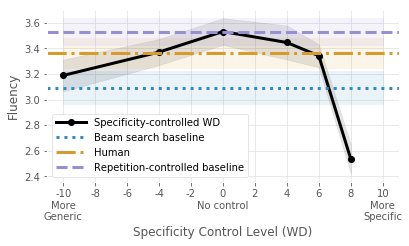

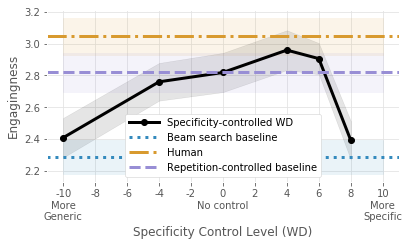

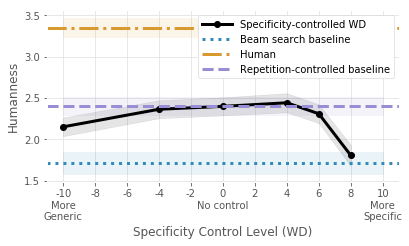

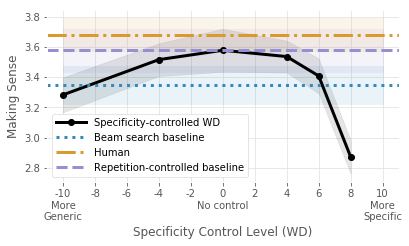

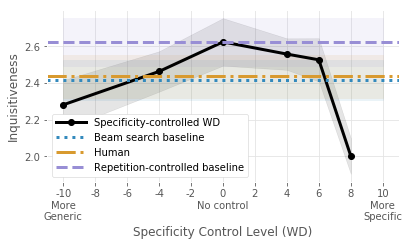

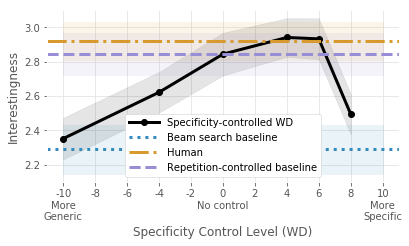

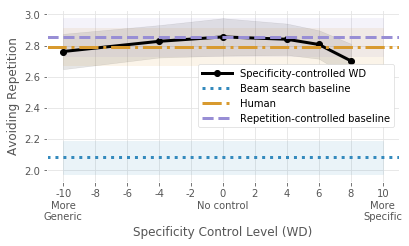

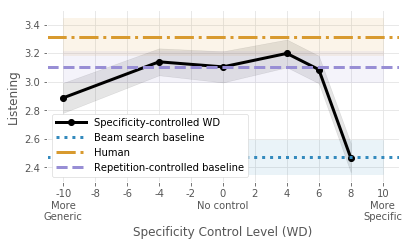

In [143]:
def plot_nidf_bfw(metric, figgca, abslim, use_title=False):
    plot_by_bucket(
        modeltype_subset(altered, ["nidf_bfw"]),
        modelname_subset(altered, ["repetition_model_setting35_settinginf", "baseline_model", "human_eval"]),
        metric,
        fig=figgca,
        xaxis='Specificity Control Level (WD)',
        xtick_values=[-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10],
        xtick_labels=['-10\nMore\nGeneric', '-8', '-6', '-4', '-2', '0\nNo control', '2', '4' , '6', '8', '10\nMore\nSpecific'],
        abslim=abslim,
        use_title=use_title,
    )

for i, m in enumerate(LIKERT_METRICS):
    fig = plt.figure(figsize=SOLO_FIG_SIZE)
    plot_nidf_bfw(m, fig.gca(), None)
    fig.savefig(HOME + "/plots/{}_{}.pdf".format('nidf-bfw', m), bbox_inches='tight', transparent=True)

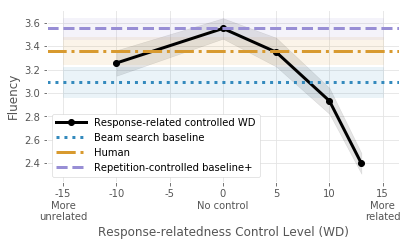

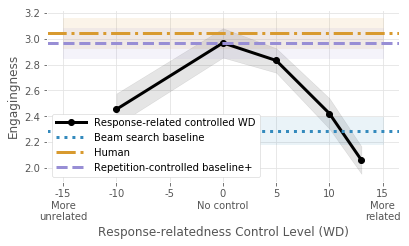

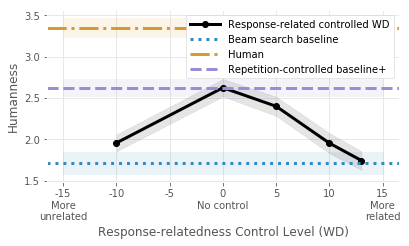

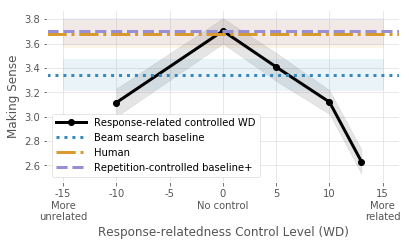

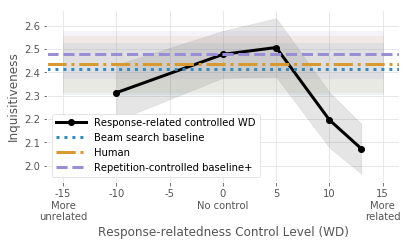

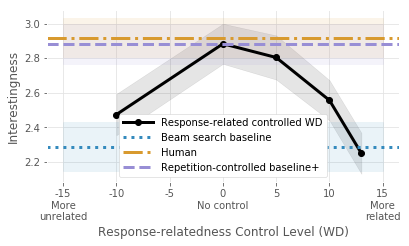

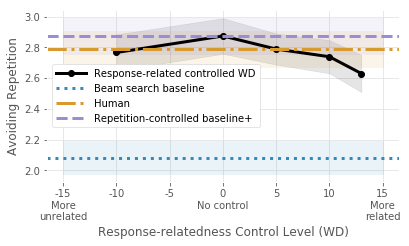

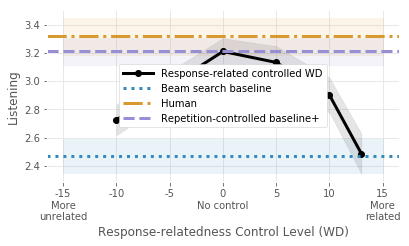

In [144]:
def plot_resp_wd(metric, figgca, abslim, xaxis='Response-relatedness Control Level (WD)', use_title=False):
    plot_by_bucket(
        modeltype_subset(altered, ["responsive"]),
        modelname_subset(altered, ["repetition++", "baseline_model", "human_eval"]),
        metric,
        fig=figgca,
        xaxis=xaxis,
        xtick_values=[-15, -10, -5, 0, 5, 10, 15],
        xtick_labels=['-15\nMore\nunrelated', '-10', '-5', '0\nNo control', '5', '10', '15\nMore\nrelated'],
        abslim=abslim,
        use_title=use_title,
    )
    
for i, m in enumerate(LIKERT_METRICS):
    fig = plt.figure(figsize=SOLO_FIG_SIZE)
    plot_resp_wd(m, fig.gca(), None)
    fig.savefig(HOME + "/plots/{}_{}.pdf".format('resp', m), bbox_inches='tight', transparent=True)

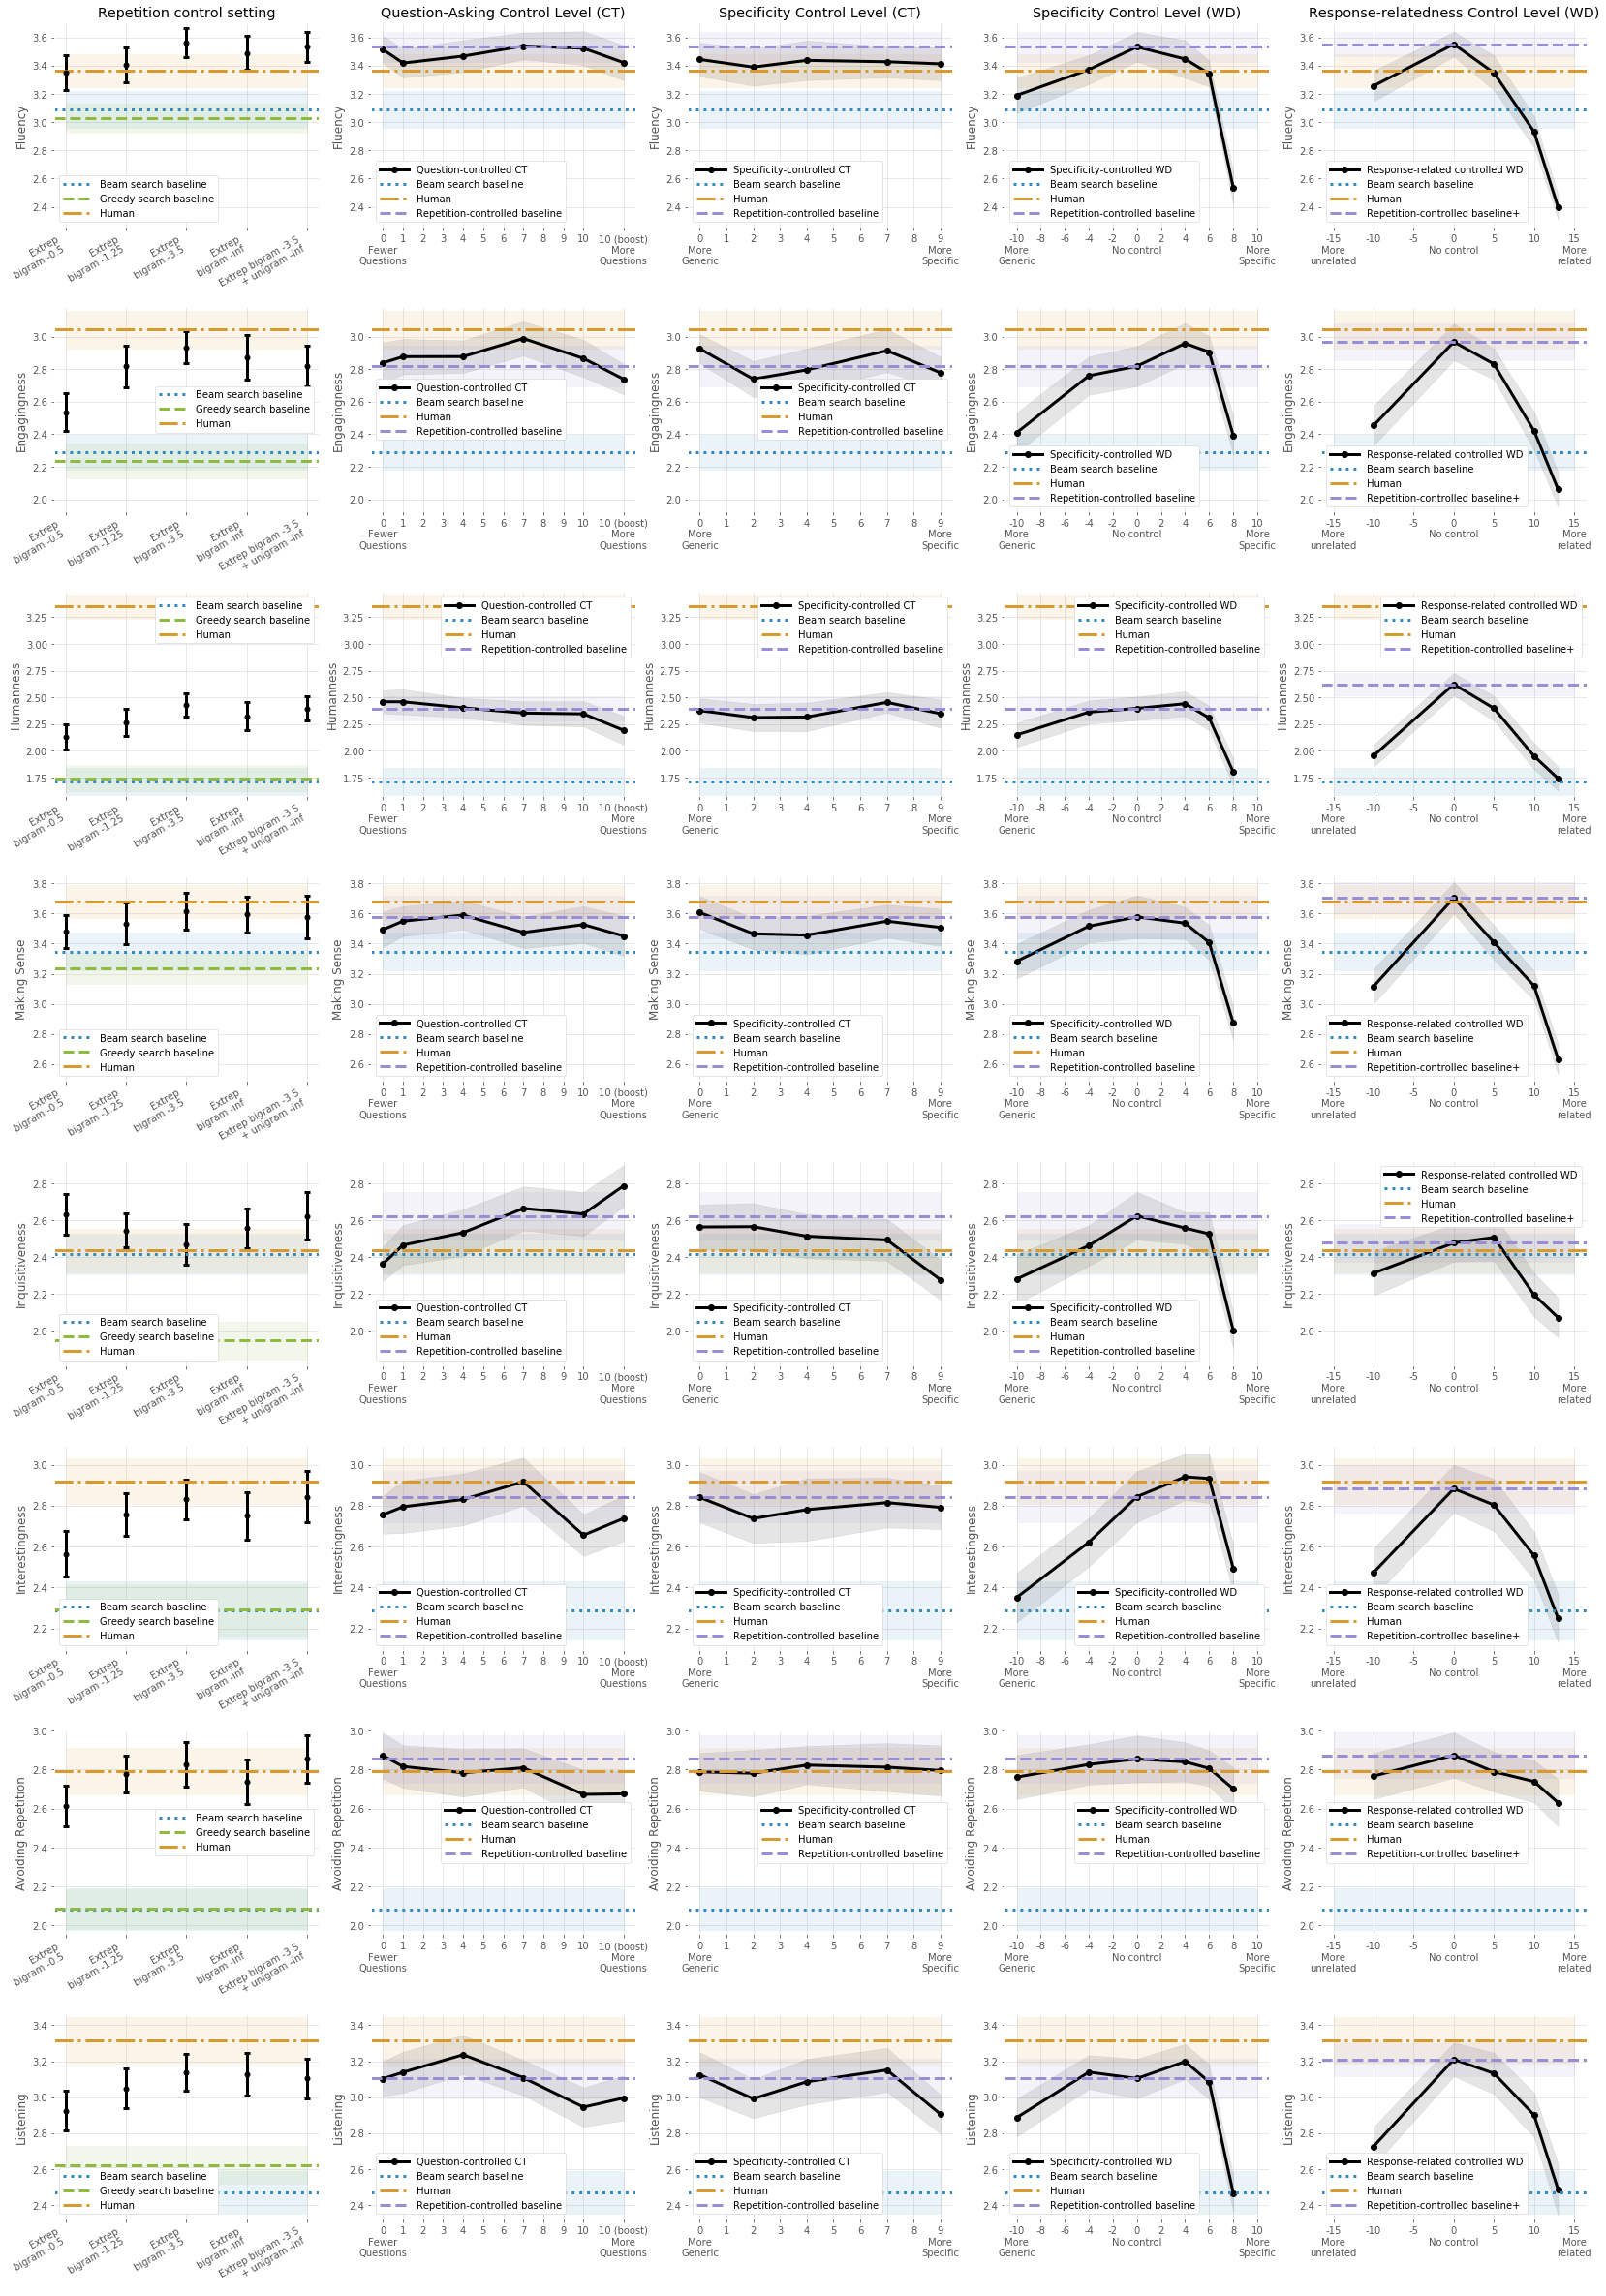

In [145]:
FULL_SIZE = (4 * 18 * CM, 4 * 20 * CM)

# the one giant plot
fig = plt.figure(figsize=FULL_SIZE)
for i, metric in enumerate(LIKERT_METRICS):
#     abslim = (1, 3) if metric == 'avoid_rep' else (1, 4)
    lower = altered[metric + '_mean'].min() - altered[metric + '_std'].max()
    upper =  altered[metric + '_mean'].max() + altered[metric + '_std'].max()
    abslim = (lower, upper)
    for j, toplot in enumerate([plot_repetition_bfw, plot_inquisitive_ct, plot_nidf_ct, plot_nidf_bfw, plot_resp_wd]):
        sub = plt.subplot(len(LIKERT_METRICS), 5, 5 * i  +  j + 1)
        if i == 0:
            toplot(metric, sub, abslim, use_title=True)
        else:
            toplot(metric, sub, abslim, use_title=None)
        
plt.subplots_adjust(top = 1, bottom=0.00, hspace=CM, wspace=0.5 * CM)
fig.savefig(HOME + "/plots/all.pdf", bbox_inches='tight', transparent=True)

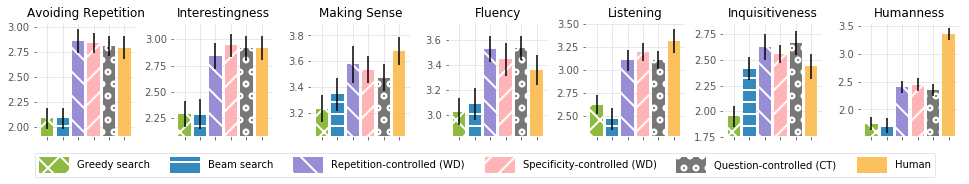

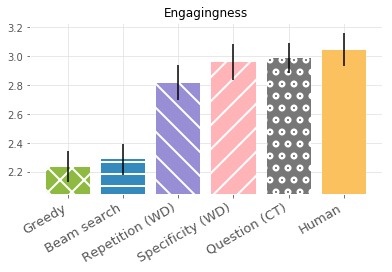

In [147]:
SPECIAL_PLOTS = [
    'enjoy',
    'inquisitive',
    'interest'
]

SPECIAL_MODELS = [
    'greedy_model',
    'baseline_model',
    'repetition_model_setting35_settinginf',
    'interesting_nidf_model_bfw_setting_04',
    'inquisitive_model_ct_setting07',
    'human_eval',
]

SPECIAL_NAMES = {
    'baseline_model': 'Beam search',
    'inquisitive_model_ct_setting07': 'Question (CT)',
    'human_eval': 'Human',
    'repetition_model_setting35_settinginf': 'Repetition (WD)',
    'interesting_nidf_model_bfw_setting_04': 'Specificity (WD)',
    'greedy_model': 'Greedy',
}

LONG_SPECIAL_NAMES = {
    'baseline_model': 'Beam search',
    'inquisitive_model_ct_setting07': 'Question-controlled (CT)',
    'human_eval': 'Human',
    'repetition_model_setting35_settinginf': 'Repetition-controlled (WD)',
    'interesting_nidf_model_bfw_setting_04': 'Specificity-controlled (WD)',
    'greedy_model': 'Greedy search',
}


HATCH = {
    'baseline_model': '-',
    'inquisitive_model_ct_setting07': 'o',
    'human_eval': '',
    'repetition_model_setting35_settinginf': '\\',
    'interesting_nidf_model_bfw_setting_04': '/',
    'greedy_model': 'x',
}

plt.rcParams['hatch.color'] = 'w'
plt.rcParams['axes.titlesize'] = 'large'
plt.rcParams['hatch.linewidth'] = 2

import textwrap

def wrap(x):
    return '\n'.join(textwrap.wrap(x, 22))


SUPER_NICE_COLORS = {
    'baseline_model': 'C1',
    'greedy_model': 'C5',
    'repetition_model_setting35_settinginf': 'C2',
    'inquisitive_model_ct_setting07': 'C3',
    'interesting_nidf_model_bfw_setting_04': 'C6',
    'human_eval': 'C4',
}

SPECIAL_PLOTS = [
    'avoid_rep',
    'interest',
    'make_sense',
    'fluency',
    'listen',
    'inquisitive',
    'turing',    
]


def super_plot(metric, figgca, abslim, use_title=None, xaxis=False, yaxis=True):
    metric_mean = metric + '_mean'
    metric_std = metric + '_std'
    
    bars = []
    for i, mn in enumerate(SPECIAL_MODELS):
        mnsubset = modelname_subset(altered, [mn])
        bar = figgca.bar(
            x=[i],
            height=mnsubset[metric_mean],
            yerr=mnsubset[metric_std],
            color=SUPER_NICE_COLORS[mn],
            lw=3,
            hatch=HATCH[mn]
        )
        bars.append(bar)

    descriptions = [
        SPECIAL_NAMES[mn]
        for mn in SPECIAL_MODELS
    ]
    
    figgca.set_xticks(range(len(SPECIAL_MODELS)))
    if xaxis:
        figgca.set_xticklabels(
            descriptions,
            fontsize=13,
            rotation=30,
            multialignment='right',
            horizontalalignment='right',
        )
    else:
        figgca.set_xticklabels(labels=[])


    if use_title:
        figgca.set_title(nice_metric_names[metric])
    elif use_title is False:
        figgca.set_xlabel('\n'.join(xaxis.split()))
    
    if yaxis:
        figgca.set_ylabel(nice_metric_names[metric])
    if abslim:
        figgca.set_ylim(abslim[0], abslim[1])
    
    limit_subset = results_bayes.loc[SPECIAL_MODELS]
    
    figgca.set_ylim(
        (limit_subset[metric_mean].min() - 1.5 * limit_subset[metric_std].max()),
        (limit_subset[metric_mean].max() + 1.5 * limit_subset[metric_std].max())
    )
    
    return bars

fig = plt.figure(figsize=(2 * 21 * CM, 4 * CM))

for i, m in enumerate(SPECIAL_PLOTS):
    plt.subplot(1, len(SPECIAL_PLOTS), i + 1)
    bar = super_plot(m, fig.gca(), None, use_title=True, xaxis=False, yaxis=False)


lgd = fig.gca().legend(
    bar,
    [LONG_SPECIAL_NAMES[mn] for mn in SPECIAL_MODELS],
    loc='lower right',
    bbox_to_anchor=(0.8, -.40),
    ncol=len(SPECIAL_MODELS),
    handlelength=3,
    handleheight=2,
)
plt.subplots_adjust(top = 1, bottom=0.0, hspace=CM, wspace=CM)


fig.savefig(
    HOME + "/plots/birthdaycandles.pdf",
    transparent=True,
    bbox_inches='tight',
)


fig = plt.figure(figsize=SOLO_FIG_SIZE)
super_plot('enjoy', fig.gca(), None, use_title=True, xaxis=True, yaxis=False)
fig.savefig(
    HOME + "/plots/special_enjoy.pdf",
    bbox_inches='tight',
    transparent=True
)
